In [7]:
# Remember you need to use SWAN with NXCALS support....
import datetime
import pytimber
ldb = pytimber.LoggingDB(source="nxcals")

In [8]:
# Just some simple imports
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('default')
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['text.usetex'] = True # sometimes best to keep it False for faster plotting...
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = 12
#plt.rcParams['font.family'] = "Helvetica"

### Interval to look at:

In [4]:
# Last week of operation 2021
t1 = '2021-11-08 00:00:00.000'
#t1 = '2021-11-14 03:00:00.000'
t2 = '2021-11-15 06:10:00.000'

# Before last week of operation. Maybe representative for typical perfomance
t1 = '2021-11-02 00:00:00.000'
t2 = '2021-11-09 00:00:00.000'

### Get data from DB
This will be the slow part of the code...

In [5]:
signals_proton = ['FTA.BCT9053:INTENSITY']

# getting this signal is very slow:
signals_intensity_AD = ['DR.BCCCA_CHARGE-SD:Samples:hotSpotsSamples']
# we should try to use: DR.BCCCA_CHARGE-SD:SamplesAtHotSpots:samples (but too late, I did not logged it before end of run 2021)
# trying to replace it with this other one (not so precise configuration of timings!):
signals_intensity_AD = ['ADE.BCCCA:Acquisition:numOfChargesPerFlatTop']

signals_intensity_ELENA = ['LNR.APULB.0027:INTENSITY', 'LNE.APULB.0030:INTENSITY','LNE.APULB.5030:INTENSITY']

extractedData = ldb.get(signals_proton+signals_intensity_AD+signals_intensity_ELENA, t1, t2)

In [6]:
# if one wants to filter by destination, one can use the following variables:
signals_destination = ['ELENA.TGM:PARTY','ELENA.TGM:WITHOUT_BEAM','ELENA.TGM:DYN_DEST_AEGIS', 'ELENA.TGM:DYN_DEST_ALPHA','ELENA.TGM:DYN_DEST_ASACUSA1','ELENA.TGM:DYN_DEST_ASACUSA2', 'ELENA.TGM:DYN_DEST_BASE', 'ELENA.TGM:DYN_DEST_GBAR']
beamDestinationData = ldb.get(signals_destination, t1, t2)

### Note: data could be stored on your local disk in the form of a database:

This would allow one to get data, save it in a local "database", and re-extract it later stage from a local db (i.e. without the need of NXCALS and its latency...)

**Save the data:**
```
from pytimber import pagestore
mydb = pagestore.PageStore('mydata.db', './datadb')
mydb.store(extractedData)
mydb.store(beamDestinationData)
```

**Load the data:**
```
extractedData = mydb.get(signals_proton+signals_intensity_AD+signals_intensity_ELENA, t1, t2)
beamDestinationData = mydb.get(signals_destination, t1, t2)
```

### Treat all data

In [10]:
# Protons - easy, single value
proton_times  = np.array([datetime.datetime.fromtimestamp(_time) for _time in extractedData[signals_proton[0]][0]])
proton_values = extractedData[signals_proton[0]][1]

In [11]:
# AD: more or less simple, sampler with data inside
pbar_ad_times = np.array([datetime.datetime.fromtimestamp(_time) for _time in extractedData[signals_intensity_AD[0]][0]])

#   This works only for 'DR.BCCCA_CHARGE-SD:Samples:hotSpotsSamples'
#_BCCCADATA_XS_values = np.array(extractedData[signals_intensity_AD[0]][1])[:, 0, :]
#   This should work also for 'ADE.BCCCA:Acquisition:numOfChargesPerFlatTop'
_BCCCADATA_XS_values = np.array(extractedData[signals_intensity_AD[0]][1]).reshape(-1, 8) 

pbar_ad_injected  = _BCCCADATA_XS_values[:, 0]
pbar_ad_extracted = _BCCCADATA_XS_values[:, 7]
ad_transmission   = 100*np.divide(pbar_ad_extracted, pbar_ad_injected)

In [12]:
# ELENA: more or less simple, but need to filter pbar cycles
# Profiting of 'ELENA.TGM:PARTY' which is logged for each cycle and tells which particle this cycle has...

# 1. create a dict to distinguish which particle type we are looking at
_party_stamp = beamDestinationData[signals_destination[0]][0]
_party_value = beamDestinationData[signals_destination[0]][1]
particle_per_cycle = dict(zip(_party_stamp, _party_value))

# 2. injected intensity
elena_injected_stamps = extractedData[signals_intensity_ELENA[0]][0]
elena_injected_values = extractedData[signals_intensity_ELENA[0]][1]
elena_injected_times  = np.array([datetime.datetime.fromtimestamp(_time) for _time in elena_injected_stamps])
elena_injected_party  = [particle_per_cycle[_stamp] if _stamp in particle_per_cycle else None for _stamp in elena_injected_stamps]
elena_injected_pbars  = [_aux == 'PBAR' for _aux in elena_injected_party]

# 3. similar, ejected intensities
elena_LNE00_stamps = extractedData[signals_intensity_ELENA[1]][0]
elena_LNE00_values = extractedData[signals_intensity_ELENA[1]][1]
elena_LNE00_times  = np.array([datetime.datetime.fromtimestamp(_time) for _time in elena_LNE00_stamps])
elena_LNE00_party  = [particle_per_cycle[_stamp] if _stamp in particle_per_cycle else None for _stamp in elena_LNE00_stamps]
elena_LNE00_pbars  = [_aux == 'PBAR' for _aux in elena_LNE00_party]

elena_LNE50_stamps = extractedData[signals_intensity_ELENA[2]][0]
elena_LNE50_values = extractedData[signals_intensity_ELENA[2]][1]
elena_LNE50_times  = np.array([datetime.datetime.fromtimestamp(_time) for _time in elena_LNE50_stamps])
elena_LNE50_party  = [particle_per_cycle[_stamp] if _stamp in particle_per_cycle else None for _stamp in elena_LNE50_stamps]
elena_LNE50_pbars  = [_aux == 'PBAR' for _aux in elena_LNE50_party]

### Make some plot

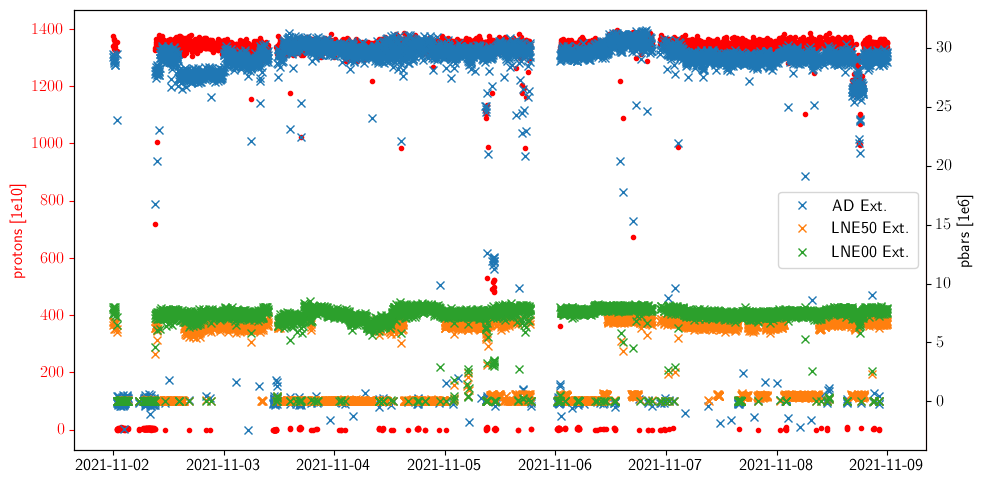

In [13]:
# Simple plot with all main intensities for the whole week
plt.figure()
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(proton_times, proton_values, 'r.', label='Protons')
ax1.set_ylabel('protons [1e10]', color='r')
ax1.spines['right'].set_color('r')
ax1.tick_params(axis='y', colors='r')

ax2.plot(pbar_ad_times, pbar_ad_extracted/1e6, 'x', label='AD Ext.')
ax2.plot(elena_LNE50_times[elena_LNE50_pbars], elena_LNE50_values[elena_LNE50_pbars], 'x', label='LNE50 Ext.')
ax2.plot(elena_LNE00_times[elena_LNE00_pbars], elena_LNE00_values[elena_LNE00_pbars], 'x', label='LNE00 Ext.')
ax2.set_ylabel("pbars [1e6]")
ax2.legend()

# A different way of treating data using pandas

In [14]:
# Use pandas store and treat all data
import pandas as pd

# calibration factor correction for hminus at injection
hminus_inj_calib = 4.3/32.25

# define a list of names with known users (TODO: redundant! find better way...)
users = ['AEGIS','ALPHA', 'ASACUSA1', 'ASACUSA2', 'BASE', 'GBAR']

for destination in signals_destination:
    _stamp = beamDestinationData[destination][0]
    _value = beamDestinationData[destination][1]
    
    if destination == 'ELENA.TGM:PARTY':
        beamDestinationDF = pd.DataFrame(_value, index =_stamp, columns =['PARTY'])
    else:
        _name = destination.split(sep='_')[-1]
        # convert type to bool, easier to use later
        _value = _value.astype(bool)
        df = pd.DataFrame(_value, index =_stamp, columns =[_name])
        beamDestinationDF = pd.concat([beamDestinationDF, df], axis=1)
        
# need to invert logic of beam (that is without_beam!)
beamDestinationDF['BEAM'] = ~beamDestinationDF['BEAM']

# create a column for 'UNKNOWN' destination
beamDestinationDF['UNKNOWN'] = ~(beamDestinationDF[users].any(axis=1))

# add data from beam
df = pd.DataFrame(elena_injected_values, index = elena_injected_stamps, columns =['ELENA Inj.'])
beamDestinationDF = pd.concat([beamDestinationDF, df], axis=1)
df = pd.DataFrame(elena_LNE00_values,    index = elena_LNE00_stamps,    columns =['LNE00 Eje.'])
beamDestinationDF = pd.concat([beamDestinationDF, df], axis=1)
df = pd.DataFrame(elena_LNE50_values,    index = elena_LNE50_stamps,    columns =['LNE50 Eje.'])
beamDestinationDF = pd.concat([beamDestinationDF, df], axis=1)

# convert timestamps to local datetime
beamDestinationDF.index = pd.to_datetime((beamDestinationDF.index*1e9).astype(int), utc=True).tz_convert('CET')

# remove corrupted data (cause we got intensities, but not beam type and so on...)
_aux = len(beamDestinationDF[beamDestinationDF['BEAM'].isna()])
if _aux > 0:
    print('Detected {} corrupted data'.format(_aux))
    beamDestinationDF = beamDestinationDF[~beamDestinationDF['BEAM'].isna()]

# fix calibration factor of H- beams injected intensity
beamDestinationDF.loc[beamDestinationDF['PARTY']=='HMINUS', 'ELENA Inj.'] *= hminus_inj_calib

# let's have a quick look at how it looks like for "useful", i.e. with BEAM, cycles:
beamDestinationDF[beamDestinationDF['BEAM']].head()

PARTY  BEAM  AEGIS  ALPHA  ASACUSA1  \
2021-11-02 00:01:00.532999936+01:00  PBAR  True  False   True     False   
2021-11-02 00:03:19.732999936+01:00  PBAR  True  False   True     False   
2021-11-02 00:05:38.933000192+01:00  PBAR  True  False   True     False   
2021-11-02 00:07:58.133000192+01:00  PBAR  True  False   True     False   
2021-11-02 00:10:17.332999936+01:00  PBAR  True  False   True     False   

                                     ASACUSA2  BASE  GBAR  UNKNOWN  \
2021-11-02 00:01:00.532999936+01:00     False  True  True    False   
2021-11-02 00:03:19.732999936+01:00     False  True  True    False   
2021-11-02 00:05:38.933000192+01:00     False  True  True    False   
2021-11-02 00:07:58.133000192+01:00     False  True  True    False   
2021-11-02 00:10:17.332999936+01:00     False  True  True    False   

                                     ELENA Inj.  LNE00 Eje.  LNE50 Eje.  
2021-11-02 00:01:00.532999936+01:00   33.649601      7.3878      6.4920  
2021-11-02 00:03:19.732999936+01:00   33.936600      8.0122      6.7499  
2021-11-02 00:05:38.933000192+01:00   34.307499      7.8816      6.8249  
2021-11-02 00:07:58.133000192+01:00   33.723801      7.7888      6.6612  
2021-11-02 00:10:17.332999936+01:00   34.126900      8.0231      6.8488

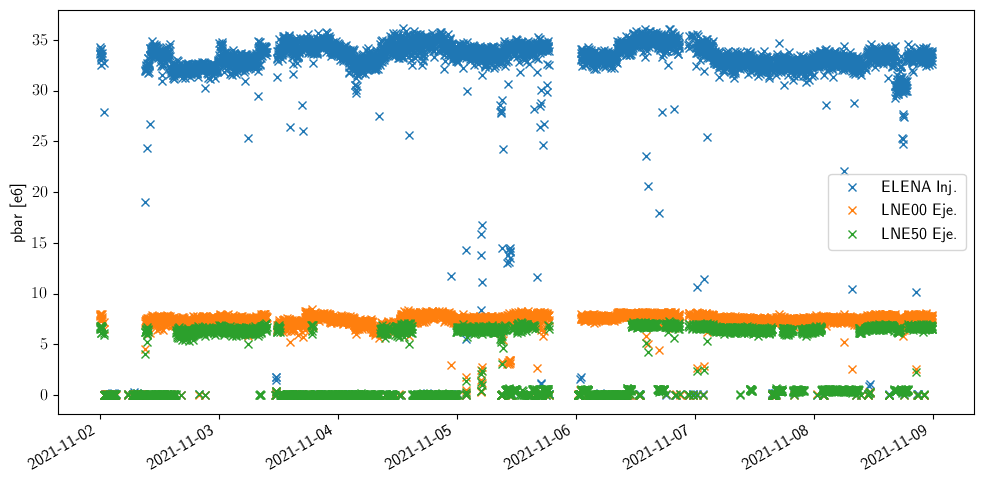

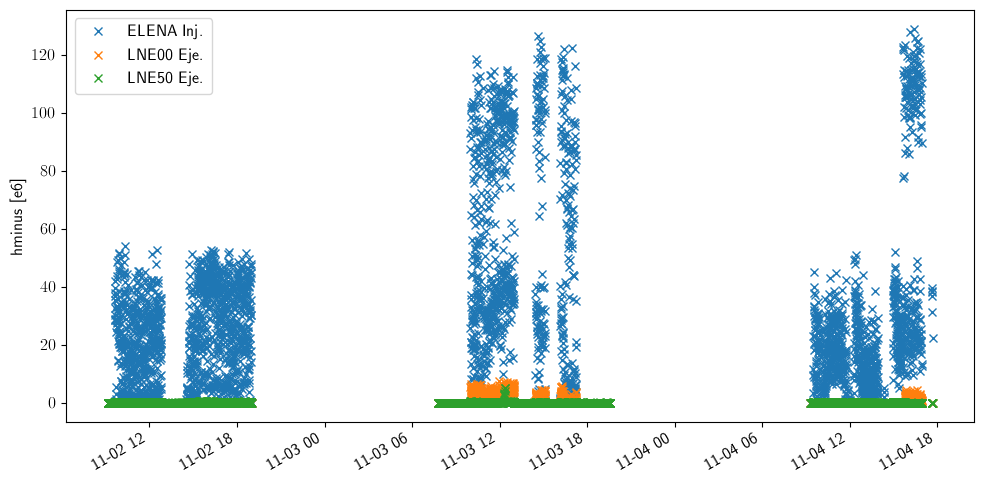

In [15]:
# Make a simple plot for pbars and hminus
for particle in ['PBAR', 'HMINUS']:
    beamDestinationDF[beamDestinationDF['BEAM'] & (beamDestinationDF['PARTY']==particle)][['ELENA Inj.','LNE00 Eje.','LNE50 Eje.']].plot(marker='x',linestyle='')
    plt.ylabel(particle.lower()+' [e6]')

##### More interesting: look at stats per destination

In [19]:
plt.rcParams['text.usetex'] = True # sometimes best to keep it False for faster plotting...

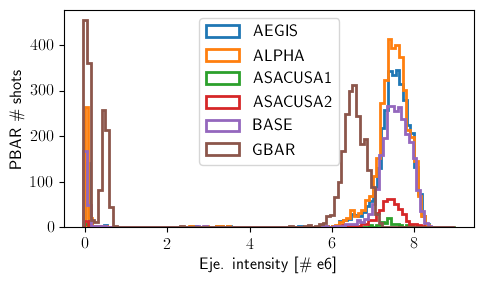

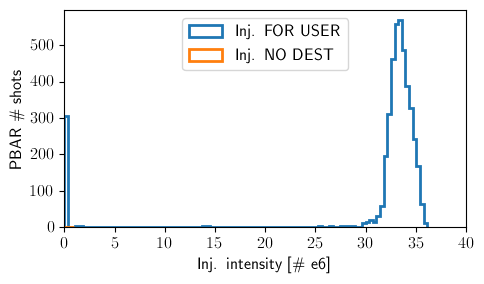

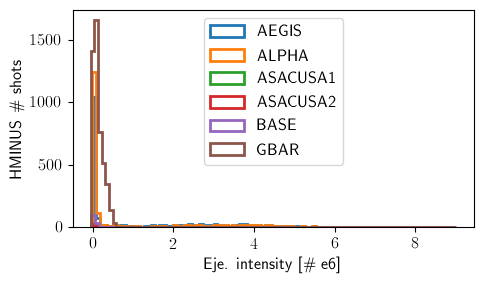

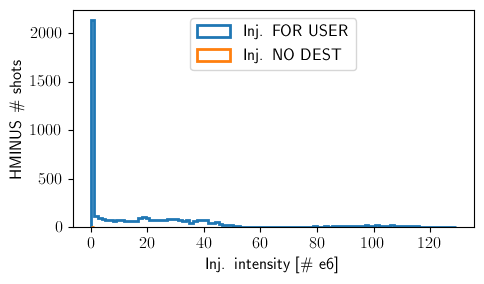

In [24]:
for particle in ['PBAR', 'HMINUS']:
    # extracted intensity per user
    nbins = 100
    bins = np.linspace(0,9,nbins)
    auxdelta = (bins[1]-bins[0])/10
    plt.figure(figsize=[5,3])
    ax1 = plt.gca()
    for i, user in enumerate(users):
        if user in ['GBAR','PUMA']:
            beamDestinationDF[beamDestinationDF['BEAM'] & (beamDestinationDF['PARTY']==particle) & beamDestinationDF[user]]['LNE50 Eje.'].hist(ax=ax1, bins=bins-i*auxdelta, grid=False, histtype=u'step', linewidth=2, label=user)
        else:
            beamDestinationDF[beamDestinationDF['BEAM'] & (beamDestinationDF['PARTY']==particle) & beamDestinationDF[user]]['LNE00 Eje.'].hist(ax=ax1, bins=bins-i*auxdelta, grid=False, histtype=u'step', linewidth=2, label=user)

    plt.legend(loc='upper center')
    plt.ylabel(particle+' \# shots')
    plt.xlabel('Eje. intensity [\# e6]')
    plt.savefig(particle+'extracted_per_user.pdf')

    # injected intensities
    plt.figure(figsize=[5,3])
    ax1 = plt.gca()
    beamDestinationDF[beamDestinationDF['BEAM'] & (beamDestinationDF['PARTY']==particle) & ~beamDestinationDF['UNKNOWN']]['ELENA Inj.'].hist(ax=ax1, bins=nbins, grid=False, histtype=u'step', linewidth=2, label='Inj. FOR USER')
    beamDestinationDF[beamDestinationDF['BEAM'] & (beamDestinationDF['PARTY']==particle) &  beamDestinationDF['UNKNOWN']]['ELENA Inj.'].hist(ax=ax1, bins=nbins, grid=False, histtype=u'step', linewidth=2, label='Inj. NO DEST')
    plt.legend(loc='upper center')
    plt.ylabel(particle+' \# shots')
    plt.xlabel('Inj. intensity [\# e6]')
    if particle == 'PBAR':
        plt.xlim([0, 40])

##### Similar, but plot density distibution [TODO]

(0.0, 40.0)

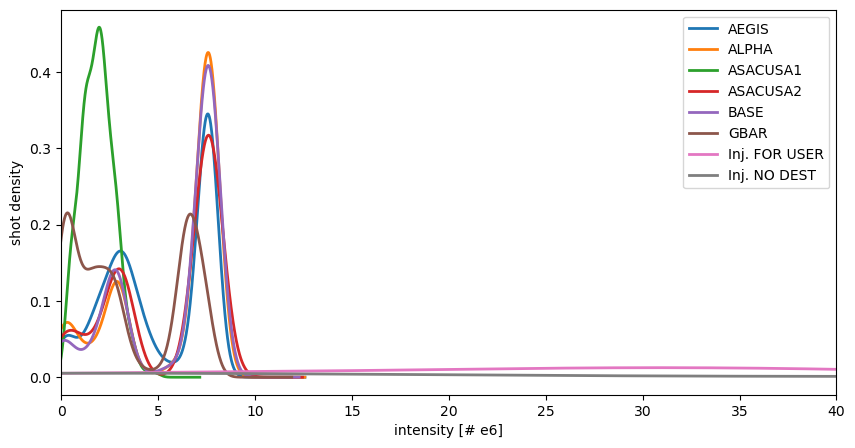

In [214]:

# extraction per user
plt.figure()
ax1 = plt.gca()
for user in users:
    if len(beamDestinationDF[beamDestinationDF['BEAM'] & beamDestinationDF[user]]) < 1:
        print('No shots for '.format(user))
        continue
    if user in ['GBAR','PUMA']:
        beamDestinationDF[beamDestinationDF['BEAM'] & beamDestinationDF[user]]['LNE50 Eje.'].plot(ax=ax1, kind = "kde", label=user)
    else:
        beamDestinationDF[beamDestinationDF['BEAM'] & beamDestinationDF[user]]['LNE00 Eje.'].plot(ax=ax1, kind = "kde", label=user)

# Add injected intensities
beamDestinationDF[beamDestinationDF['BEAM'] & ~beamDestinationDF['UNKNOWN']]['ELENA Inj.'].plot(ax=ax1, kind = "kde", label='Inj. FOR USER')
beamDestinationDF[beamDestinationDF['BEAM'] &  beamDestinationDF['UNKNOWN']]['ELENA Inj.'].plot(ax=ax1, kind = "kde", label='Inj. NO DEST')
plt.legend()
plt.ylabel('shot density')
plt.xlabel('intensity [# e6]')
plt.xlim([0, 40])